In [1]:
import pandas as pd
import numpy as np

import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = f'drive/MyDrive/datasets/Копия отправка_комбинации поддержка после ПХТ 3 стадия.xlsx'

In [4]:
data = pd.read_excel(file_path)

In [5]:
df = data.copy()
df.head(2)

,id_ответа,Раса,Пол,Возраст,Статус курения,ECOG,Есть опухолевая нагрузка? (симптомная опухоль),Ко-мутации KRAS,Ко-мутации p53.,Ко-мутации STK11,...,Срок от окончания ХЛТ,Молекулярный статус (только для неплоскоклеточного рака),PD-L1 статус,Предпочтение пациента по ответу на терапию,Ответ эксперта (Лактионов),"Поставьте галочку, если уверены на 100%",Если 75%,Если 50%,"Альтернатива, если 50% - обязательно",Комментарий
0,1,Азиатская,Мужской,До 70,В настоящее время,0-1,да,да,да,да,...,до 42 дней,нет мутаций,Не исследовался,Результативность лечения,Дурвалумаб,True,False,False,0,0
1,2,Азиатская,Мужской,До 70,В настоящее время,0-1,да,да,да,да,...,от 43 до 60 дней,нет мутаций,Не исследовался,Результативность лечения,Дурвалумаб,True,False,False,0,0


In [6]:
# Удаление ненужных столбцов
df.drop(columns=['id_ответа', 'Комментарий', 'Альтернатива, если 50% - обязательно'], inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248832 entries, 0 to 248831
Data columns (total 18 columns):
 #   Column                                                    Non-Null Count   Dtype 
---  ------                                                    --------------   ----- 
 0   Раса                                                      248832 non-null  object
 1   Пол                                                       248832 non-null  object
 2   Возраст                                                   248832 non-null  object
 3   Статус курения                                            248832 non-null  object
 4   ECOG                                                      248832 non-null  object
 5   Есть опухолевая нагрузка? (симптомная опухоль)            248832 non-null  object
 6   Ко-мутации KRAS                                           248832 non-null  object
 7   Ко-мутации p53.                                           248832 non-null  object
 8   Ко-мутации STK

In [8]:
# Проверка наличия пропущенных значений в каждом столбце
missing_values = df.isnull().sum()
print("Пропущенные значения в каждом столбце:\n", missing_values)

Пропущенные значения в каждом столбце:
 Раса                                                        0
Пол                                                         0
Возраст                                                     0
Статус курения                                              0
ECOG                                                        0
Есть опухолевая нагрузка? (симптомная опухоль)              0
Ко-мутации KRAS                                             0
Ко-мутации p53.                                             0
Ко-мутации STK11                                            0
Ко-мутации KEAP1                                            0
Срок от окончания ХЛТ                                       0
Молекулярный статус (только для неплоскоклеточного рака)    0
PD-L1 статус                                                0
Предпочтение пациента по ответу на терапию                  0
Ответ эксперта (Лактионов)                                  0
Поставьте галочку, если уверен

In [9]:
# Проверка уникальных значений каждого столбца
for col in df.columns:
    print(f'Уникальные значения столбца {col}: {df[col].unique()}')

Уникальные значения столбца Раса: ['Азиатская' 'Европейская' 'Другая']
Уникальные значения столбца Пол: [' Мужской' ' Женский']
Уникальные значения столбца Возраст: [' До 70' ' >70']
Уникальные значения столбца Статус курения: [' В настоящее время'
 ' Курение в прошлом (бросил более 1 месяца до 1 года)'
 ' Курение в прошлом (бросил более 1 года)']
Уникальные значения столбца ECOG: [' 0-1' 2]
Уникальные значения столбца Есть опухолевая нагрузка? (симптомная опухоль): [' да' ' нет']
Уникальные значения столбца Ко-мутации KRAS: [' да' ' нет']
Уникальные значения столбца Ко-мутации p53.: [' да' ' нет']
Уникальные значения столбца Ко-мутации STK11: [' да' ' нет']
Уникальные значения столбца Ко-мутации KEAP1: [' да' ' нет']
Уникальные значения столбца Срок от окончания ХЛТ: ['до 42 дней' 'от 43 до 60 дней' 'более 61 дня']
Уникальные значения столбца Молекулярный статус (только для неплоскоклеточного рака): [' нет мутаций' ' не исследовались' ' EGFR редкий вариант' ' EGFR ex19'
 ' EGFR ex21' 

In [10]:
df['ECOG'] = df['ECOG'].astype(str)

In [11]:
# Создание нового столбца "Уверенность"
df['Уверенность'] = 'Нет уверенности'

# Заполнение столбца "Уверенность" в зависимости от значений в трех указанных столбцах
df.loc[df['Поставьте галочку, если уверены на 100%'], 'Уверенность'] = '100%'
df.loc[df['Если 75%'], 'Уверенность'] = '75%'
df.loc[df['Если 50%'], 'Уверенность'] = '50%'

df.drop(columns=['Поставьте галочку, если уверены на 100%', 'Если 75%', 'Если 50%'], inplace=True)
df.head(2)

,Раса,Пол,Возраст,Статус курения,ECOG,Есть опухолевая нагрузка? (симптомная опухоль),Ко-мутации KRAS,Ко-мутации p53.,Ко-мутации STK11,Ко-мутации KEAP1,Срок от окончания ХЛТ,Молекулярный статус (только для неплоскоклеточного рака),PD-L1 статус,Предпочтение пациента по ответу на терапию,Ответ эксперта (Лактионов),Уверенность
0,Азиатская,Мужской,До 70,В настоящее время,0-1,да,да,да,да,да,до 42 дней,нет мутаций,Не исследовался,Результативность лечения,Дурвалумаб,100%
1,Азиатская,Мужской,До 70,В настоящее время,0-1,да,да,да,да,да,от 43 до 60 дней,нет мутаций,Не исследовался,Результативность лечения,Дурвалумаб,100%


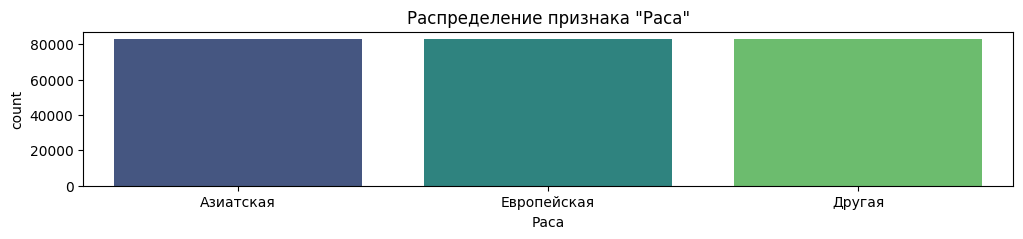

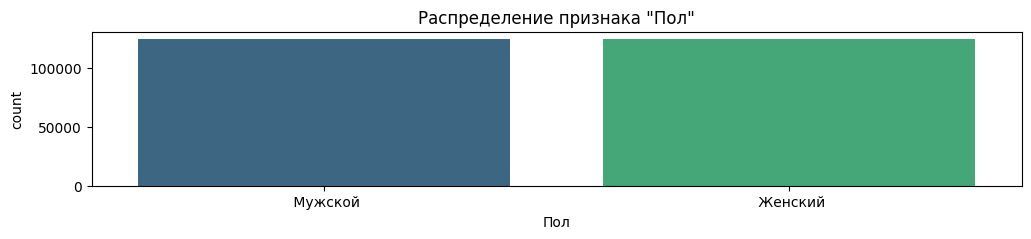

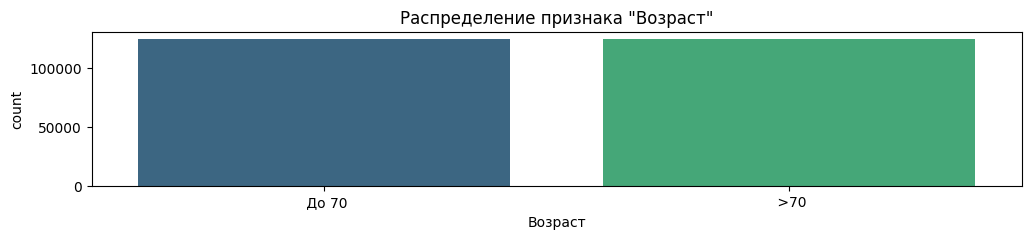

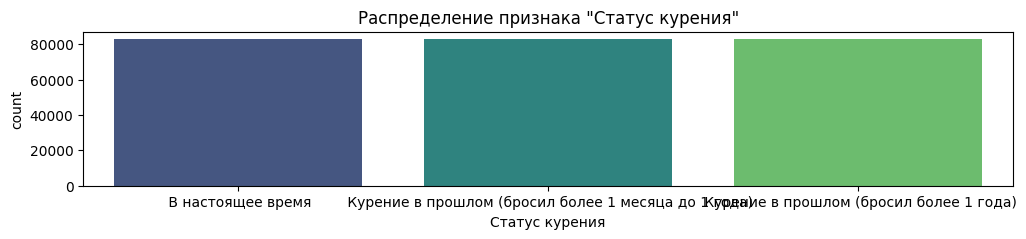

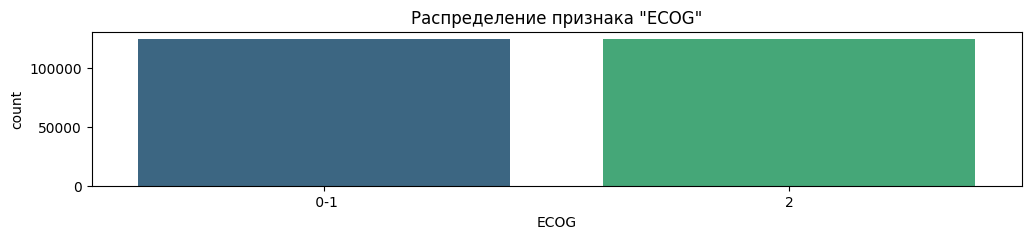

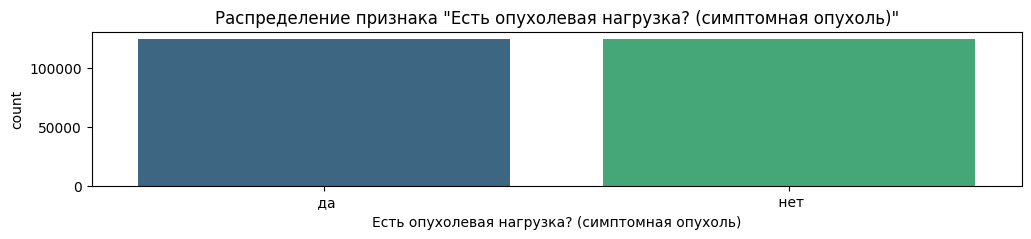

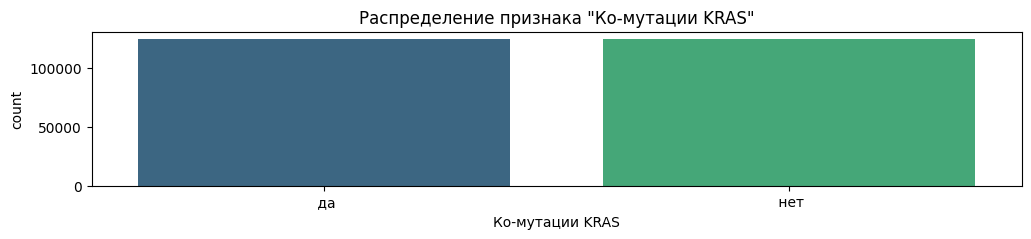

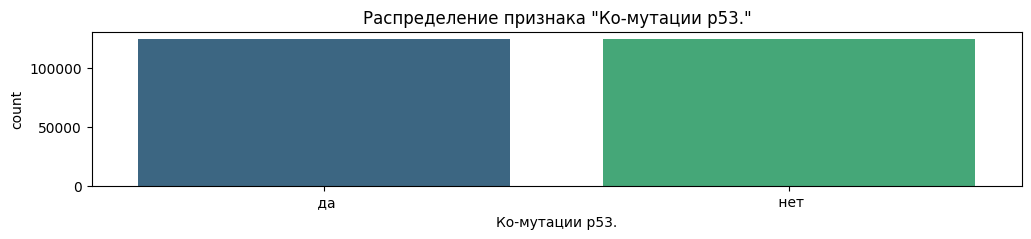

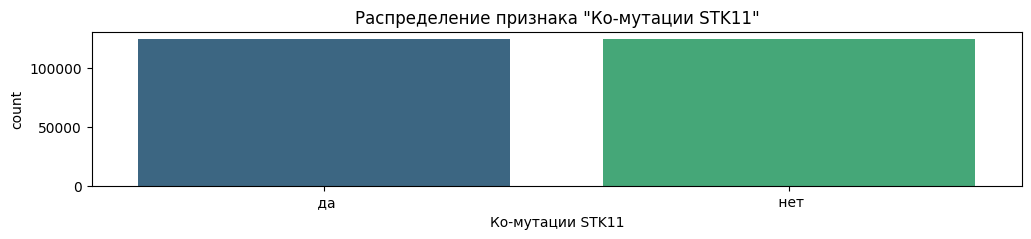

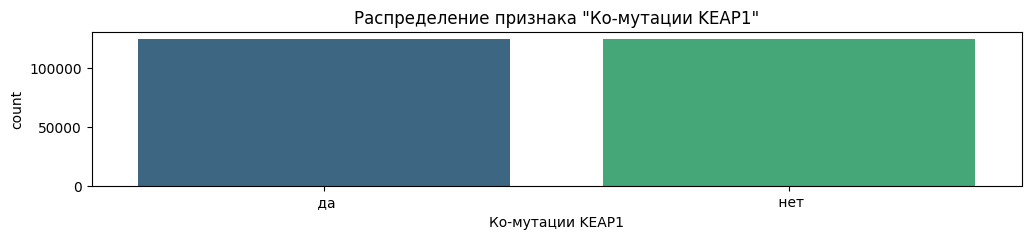

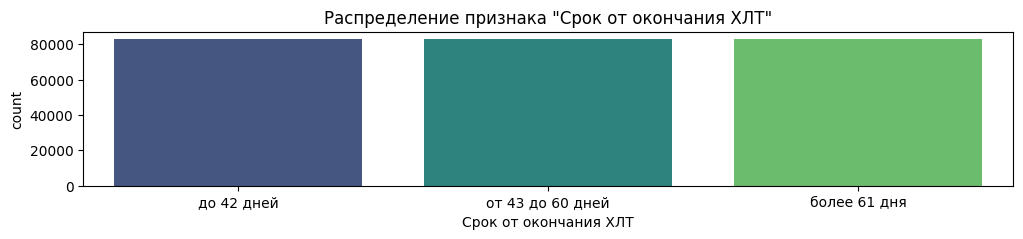

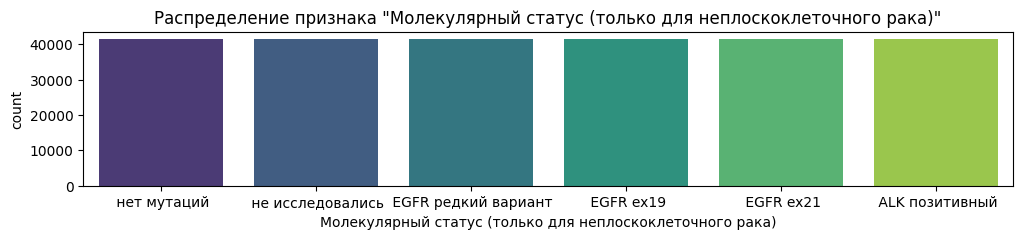

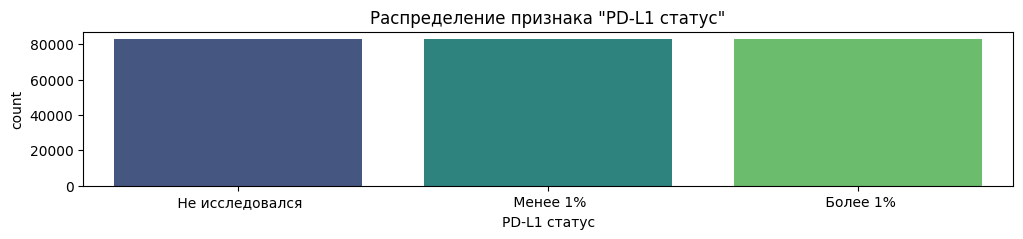

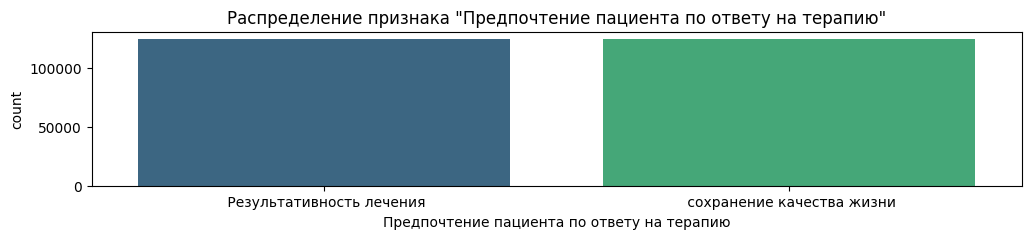

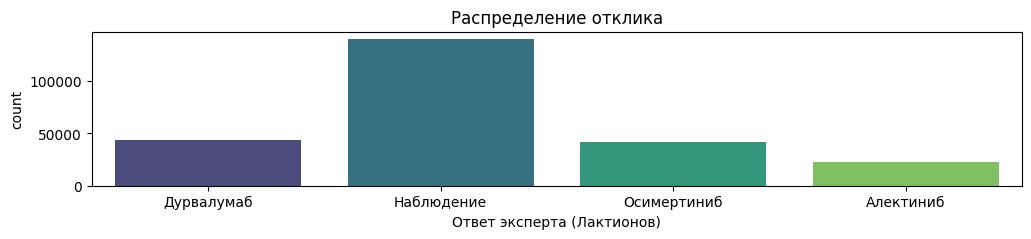

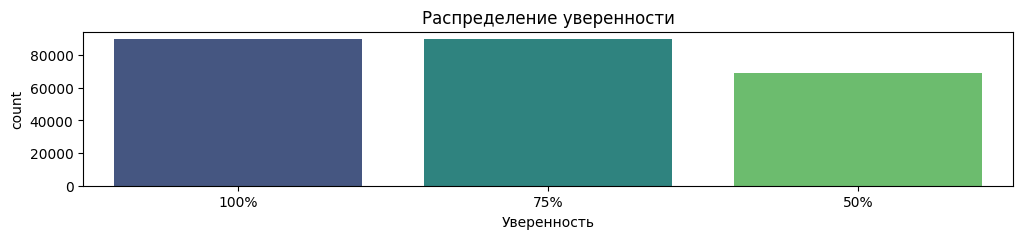

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 10

# Построение диаграмм распределения для каждого признака
for column in df.columns[:-2]:
    plt.figure(figsize=(12, 2))
    sns.countplot(x=column, data=df, palette='viridis')
    plt.title(f'Распределение признака "{column}"')

    plt.show()

# Построение диаграмм распределения для целевых переменных
plt.figure(figsize=(12, 2))
sns.countplot(x='Ответ эксперта (Лактионов)', data=df, palette='viridis')
plt.title('Распределение отклика')
plt.show()

plt.figure(figsize=(12, 2))
sns.countplot(x='Уверенность', data=df, palette='viridis')
plt.title('Распределение уверенности')
plt.show()


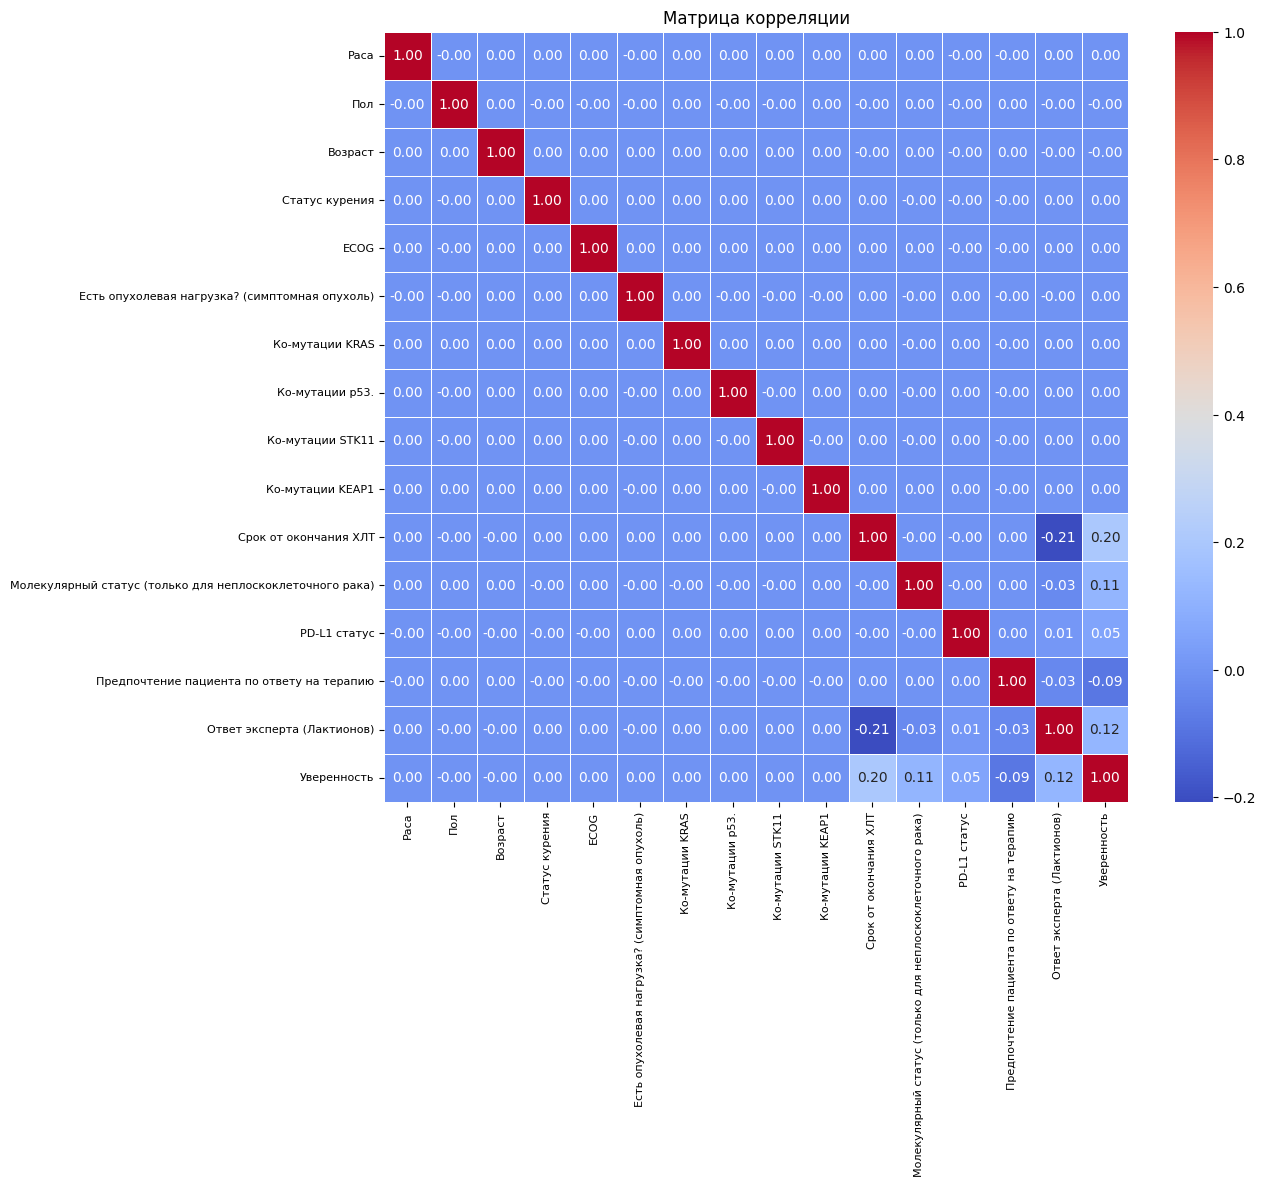

In [13]:
# Построение матрицы корреляций
import seaborn as sns

df_encoded = df.apply(lambda x: x.astype('category').cat.codes)

correlation_matrix = df_encoded.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, annot_kws={'size': 10})
plt.title('Матрица корреляции')

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()


In [14]:
df.columns

Index(['Раса', 'Пол', 'Возраст', 'Статус курения', 'ECOG',
       'Есть опухолевая нагрузка? (симптомная опухоль)', 'Ко-мутации KRAS',
       'Ко-мутации p53.', 'Ко-мутации STK11', 'Ко-мутации KEAP1',
       'Срок от окончания ХЛТ',
       'Молекулярный статус (только для неплоскоклеточного рака)',
       'PD-L1 статус', 'Предпочтение пациента по ответу на терапию',
       'Ответ эксперта (Лактионов)', 'Уверенность'],
      dtype='object')

In [15]:
# Удаление столбцов ['Ответ эксперта (Лактионов)', 'Уверенность']
df_without_target = df.drop(columns=['Ответ эксперта (Лактионов)', 'Уверенность'])

# Преобразование категориальных переменных методом One-Hot Encoding
df_encoded = pd.get_dummies(df_without_target, drop_first=True)

# Определение целевых переменных и признаков
X = df_encoded.copy()
y_response = df['Ответ эксперта (Лактионов)']
y_confidence = df['Уверенность']

In [16]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(X, y_response)

# Оценка важности признаков для первой целевой переменной
importance_response = model.feature_importances_

model.fit(X, y_confidence)

# Оценка важности признаков для второй целевой переменной
importance_confidence = model.feature_importances_

# Усреднение значений важности признаков
average_importance = (importance_response + importance_confidence) / 2

In [17]:
average_importance

array([0.00147243, 0.00149159, 0.00206732, 0.00206812, 0.00148951,
       0.00147811, 0.00210562, 0.0020481 , 0.00214757, 0.00215576,
       0.00208817, 0.00204877, 0.19283362, 0.09847682, 0.11338668,
       0.07766971, 0.14327845, 0.08674567, 0.08345746, 0.04928427,
       0.02492564, 0.1072806 ])

In [18]:
y_confidence.unique()

array(['100%', '75%', '50%'], dtype=object)

In [19]:
y_response.unique()

array(['Дурвалумаб', 'Наблюдение', 'Осимертиниб', 'Алектиниб'],
      dtype=object)

In [20]:
from sklearn.model_selection import train_test_split

# Разделение данных на обучающий и тестовый наборы для response
X_train_response, X_test_response, y_train_response, y_test_response = train_test_split(
    X, y_response, test_size=0.2, random_state=42)

# Разделение данных на обучающий и тестовый наборы для confidence
X_train_confidence, X_test_confidence, y_train_confidence, y_test_confidence = train_test_split(
    X, y_confidence, test_size=0.2, random_state=42)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Логистическая регрессия для response
lr_response = LogisticRegression(random_state=42)
lr_response.fit(X_train_response, y_train_response)
predictions_response = lr_response.predict(X_test_response)
accuracy_response = accuracy_score(y_test_response, predictions_response)

# Логистическая регрессия для confidence
lr_confidence = LogisticRegression(random_state=42)
lr_confidence.fit(X_train_confidence, y_train_confidence)
predictions_confidence = lr_confidence.predict(X_test_confidence)
accuracy_confidence = accuracy_score(y_test_confidence, predictions_confidence)

# Вывод результатов
print("Логистическая регрессия для response:")
print(f"Accuracy: {accuracy_response}")
print(classification_report(y_test_response, predictions_response))

print("\nЛогистическая регрессия для confidence:")
print(f"Accuracy: {accuracy_confidence}")
print(classification_report(y_test_confidence, predictions_confidence))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Логистическая регрессия для response:
Accuracy: 1.0
              precision    recall  f1-score   support

   Алектиниб       1.00      1.00      1.00      4562
  Дурвалумаб       1.00      1.00      1.00      8757
  Наблюдение       1.00      1.00      1.00     28085
 Осимертиниб       1.00      1.00      1.00      8363

    accuracy                           1.00     49767
   macro avg       1.00      1.00      1.00     49767
weighted avg       1.00      1.00      1.00     49767


Логистическая регрессия для confidence:
Accuracy: 0.7415757429622039
              precision    recall  f1-score   support

        100%       0.83      0.77      0.80     17914
         50%       0.78      0.73      0.76     13910
         75%       0.64      0.72      0.68     17943

    accuracy                           0.74     49767
   macro avg       0.75      0.74      0.75     49767
weighted avg       0.75      0.74      0.74     49767



In [22]:
from sklearn.ensemble import RandomForestClassifier

# RandomForestClassifier для response
rf_response = RandomForestClassifier(random_state=42)
rf_response.fit(X_train_response, y_train_response)
predictions_response_rf = rf_response.predict(X_test_response)
accuracy_response_rf = accuracy_score(y_test_response, predictions_response_rf)

# RandomForestClassifier для confidence
rf_confidence = RandomForestClassifier(random_state=42)
rf_confidence.fit(X_train_confidence, y_train_confidence)
predictions_confidence_rf = rf_confidence.predict(X_test_confidence)
accuracy_confidence_rf = accuracy_score(y_test_confidence, predictions_confidence_rf)

# Вывод результатов
print("RandomForestClassifier для response:")
print(f"Accuracy: {accuracy_response_rf}")
print(classification_report(y_test_response, predictions_response_rf))

print("\nRandomForestClassifier для confidence:")
print(f"Accuracy: {accuracy_confidence_rf}")
print(classification_report(y_test_confidence, predictions_confidence_rf))

RandomForestClassifier для response:
Accuracy: 1.0
              precision    recall  f1-score   support

   Алектиниб       1.00      1.00      1.00      4562
  Дурвалумаб       1.00      1.00      1.00      8757
  Наблюдение       1.00      1.00      1.00     28085
 Осимертиниб       1.00      1.00      1.00      8363

    accuracy                           1.00     49767
   macro avg       1.00      1.00      1.00     49767
weighted avg       1.00      1.00      1.00     49767


RandomForestClassifier для confidence:
Accuracy: 1.0
              precision    recall  f1-score   support

        100%       1.00      1.00      1.00     17914
         50%       1.00      1.00      1.00     13910
         75%       1.00      1.00      1.00     17943

    accuracy                           1.00     49767
   macro avg       1.00      1.00      1.00     49767
weighted avg       1.00      1.00      1.00     49767



In [23]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

# Разделение данных на обучающий и тестовый наборы для обеих целевых переменных
X_train_multioutput, X_test_multioutput, y_train_multioutput_response, y_test_multioutput_response, y_train_multioutput_confidence, y_test_multioutput_confidence = train_test_split(
    X, y_response, y_confidence, test_size=0.2, random_state=42)

# Инициализация RandomForestClassifier
rf_multioutput = RandomForestClassifier(random_state=42)

# Инициализация MultiOutputClassifier с RandomForestClassifier
multioutput_classifier = MultiOutputClassifier(rf_multioutput)

# Обучение модели на обучающих данных для обеих целевых переменных
multioutput_classifier.fit(X_train_multioutput, pd.concat([y_train_multioutput_response, y_train_multioutput_confidence], axis=1))

# Предсказание на тестовых данных
predictions_multioutput = multioutput_classifier.predict(X_test_multioutput)

# Оценка точности для обеих целевых переменных
accuracy_multioutput_response = accuracy_score(y_test_multioutput_response, predictions_multioutput[:, 0])
accuracy_multioutput_confidence = accuracy_score(y_test_multioutput_confidence, predictions_multioutput[:, 1])

# Вывод результатов
print(f"Accuracy (MultiOutput) for response: {accuracy_multioutput_response}")
print(classification_report(y_test_multioutput_response, predictions_multioutput[:, 0]))

print(f"\nAccuracy (MultiOutput) for confidence: {accuracy_multioutput_confidence}")
print(classification_report(y_test_multioutput_confidence, predictions_multioutput[:, 1]))


Accuracy (MultiOutput) for response: 1.0
              precision    recall  f1-score   support

   Алектиниб       1.00      1.00      1.00      4562
  Дурвалумаб       1.00      1.00      1.00      8757
  Наблюдение       1.00      1.00      1.00     28085
 Осимертиниб       1.00      1.00      1.00      8363

    accuracy                           1.00     49767
   macro avg       1.00      1.00      1.00     49767
weighted avg       1.00      1.00      1.00     49767


Accuracy (MultiOutput) for confidence: 1.0
              precision    recall  f1-score   support

        100%       1.00      1.00      1.00     17914
         50%       1.00      1.00      1.00     13910
         75%       1.00      1.00      1.00     17943

    accuracy                           1.00     49767
   macro avg       1.00      1.00      1.00     49767
weighted avg       1.00      1.00      1.00     49767



In [ ]:
# Очень долгое время работы (не прогружать)
from sklearn.svm import SVC

# SVM для response
svm_response = SVC(random_state=42)
svm_response.fit(X_train_response, y_train_response)
predictions_response_svm = svm_response.predict(X_test_response)
accuracy_response_svm = accuracy_score(y_test_response, predictions_response_svm)

# SVM для confidence
svm_confidence = SVC(random_state=42)
svm_confidence.fit(X_train_confidence, y_train_confidence)
predictions_confidence_svm = svm_confidence.predict(X_test_confidence)
accuracy_confidence_svm = accuracy_score(y_test_confidence, predictions_confidence_svm)

# Вывод результатов
print("SVM для response:")
print(f"Accuracy: {accuracy_response_svm}")
print(classification_report(y_test_response, predictions_response_svm))

print("\nSVM для confidence:")
print(f"Accuracy: {accuracy_confidence_svm}")
print(classification_report(y_test_confidence, predictions_confidence_svm))